In [32]:
import numpy as np
from scipy.io import loadmat
import tqdm
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
%matplotlib inline
import random
import csv

In [2]:
jokesData = loadmat("joke_data/joke_train.mat",mat_dtype=True)['train']


In [3]:
jokesData.shape
for i in range(jokesData.shape[0]):
    for j in range(jokesData.shape[1]):
        if np.isnan(jokesData[i][j]):
            jokesData[i][j] = 0

In [4]:
u,s,v = np.linalg.svd(jokesData, full_matrices=False)

In [5]:
def generateRanked(u,s,v,k):
    s2 = np.diag(s)
    for i in range(s.shape[0]):
        if i >= k:
            s2[i][i] = 0
    return u.dot(s2.dot(v))

In [6]:
d2 = generateRanked(u,s,v,2)

[4562.3260704176491, 4389.1235067537918, 4173.1649694688394, 3803.4602408597734]


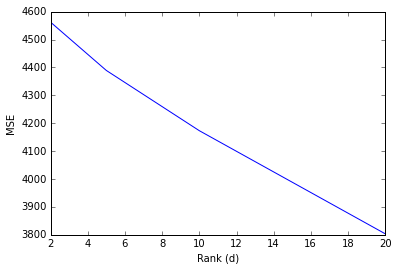

In [36]:
errors = []
for i in [2,5,10,20]:
    errors.append(np.linalg.norm(jokesData - generateRanked(u,s,v,i)))
plt.ylabel("MSE")
plt.xlabel("Rank (d)")
plt.plot([2,5,10,20],errors)
print(errors)

In [8]:
#Load validation accuracies
validationPairs = []
with open("joke_data/validation.txt") as f:
    for line in f:
        i,j,label = line[:-1].split(",")
        validationPairs.append((int(i) -1,int(j) - 1,int(label)))
        

In [9]:
def generateLowRank(u,s,v,k):
    s2 = np.diag(s)
    for i in range(s.shape[0]):
        if i >= k:
            s2[i][i] = 0
    return u.dot(s2).dot(v)
    
lowrank = generateLowRank(u,s,v,9)
def predict(lowrank,i,j,label):
    result = lowrank[i][j]
    if result > 0 and label == 1:
        return 1
    elif result <= 0 and label == 0:
        return 1
    else:
        return 0


# print(v2.shape)
correct = 0
total = len(validationPairs)
for vtriplet in validationPairs:
    correct += predict(lowrank, vtriplet[0],vtriplet[1],vtriplet[2])
print(correct/total)
# for i in validationPairs:
    

0.7214092140921409


In [10]:
def generateLowRank(u,s,v,k):
    s2 = np.diag(s)
    for i in range(s.shape[0]):
        if i >= k:
            s2[i][i] = 0
    return u.dot(np.sqrt(s2)).T[:k].T,np.sqrt(s2).dot(v)[:k]
    
newu,newv = generateLowRank(u,s,v,9)
def predict(u,v, i,j,label):
    result = np.inner(u[i],v[:,j])
    if result > 0 and label == 1:
        return 1
    elif result <= 0 and label == 0:
        return 1
    else:
        return 0


# print(v2.shape)
correct = 0
total = len(validationPairs)
for vtriplet in validationPairs:
    correct += predict(newu, newv, vtriplet[0],vtriplet[1],vtriplet[2])
print(correct/total)

0.7214092140921409


In [37]:
#Form training pairs
trainingSet = set()
for user in tqdm.tqdm(range(jokesData.shape[0])):
    for joke in range(jokesData.shape[1]):
        rating = jokesData[user][joke]
        if not np.isnan(rating):
            trainingSet.add((user,joke,rating))

100%|██████████| 24983/24983 [00:06<00:00, 3765.10it/s]


In [38]:
#SGD
l = .01
epsilon = .001
LearnU, LearnV = generateLowRank(u,s,v,9)
for i in tqdm.tqdm(range(100)):
    point = random.sample(trainingSet, 1)[0]
    error = point[2] - np.inner(LearnU[point[0]], LearnV[:, point[1]])
    LearnV[:, point[1]] = LearnV[:, point[1]] + epsilon * (LearnU[point[0]]*error - l * LearnV[:, point[1]])
    LearnU[point[0]] = LearnU[point[0]] + epsilon * (LearnV[:, point[1]]*error - l * LearnU[point[0]])
correct = 0
total = len(validationPairs)
for vtriplet in validationPairs:
    correct += predict(LearnU, LearnV, vtriplet[0],vtriplet[1],vtriplet[2])
print(correct/total)

100%|██████████| 100/100 [00:18<00:00,  5.61it/s]

0.7214092140921409


In [13]:
msebest = np.linalg.norm(jokesData - generateLowRank(u,s,v,9)[0].dot(generateLowRank(u,s,v,9)[1]))
msenew = np.linalg.norm(jokesData - LearnU.dot(LearnV))
print(msebest, msenew)

4213.26116825 4213.26932875


In [29]:
def predictActual(u,v, i,j):
    p = u[i]
    try:
        q = v[:,j]
    except:
        print(i,j)
    result = np.inner(p,q)
    if result > 0:
        return 1
    else:
        return 0
#Load test
testPairs = []
with open("joke_data/query.txt") as f:
    for line in f:
        ID,user,joke = line[:-1].split(",")        
        testPairs.append((ID,(int(user) - 1),(int(joke) - 1)))
predictions = []
for tTriplet in testPairs:
    predictions.append((tTriplet[0],predictActual(LearnU, LearnV, tTriplet[1],tTriplet[2])))



In [30]:
print(predictions[0])

('1', 1)


In [33]:
f = open('output.csv', 'wt')
try:
    writer = csv.writer(f)
    writer.writerow( ('Id', 'Category') )
    for i in range(len(predictions)):
        writer.writerow( (predictions[i][0], str(predictions[i][1])) )
finally:
    f.close()